# PINN solution for Temperature Distribution in Cryosurgery

## Model setup

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time
import os


torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

r_c = 5.0
z_c = 10.0
z_p = 5.0
t_end = 120.0

T_s = 37.0
T_o = 37.0
T_p = -196.0
Q_mu = 0.0042
C_u = 3.6
C_f = 1.8
k_f = 0.02
k_u = 0.005
Q_l = 250.0
T_ml = -8.0
T_mu = -1.0

w_pde = 8.0
w_ic = 10.0
w_bc = 10.0
w_point = 50.0

t_min, t_max = 0, t_end
r_min, r_max = 0, r_c
z_min, z_max = 0, z_c


def C(T):
    cond1 = T < T_ml
    cond2 = (T >= T_ml) & (T <= T_mu)
    cond3 = T > T_mu

    val1 = torch.full_like(T, C_f)
    val2 = Q_l / (T_mu - T_ml) + (C_f + C_u) / 2
    val3 = torch.full_like(T, C_u)

    return torch.where(cond1, val1, torch.where(cond2, val2, val3))


def k(T):
    cond1 = T < T_ml
    cond2 = (T >= T_ml) & (T <= T_mu)
    cond3 = T > T_mu

    val1 = torch.full_like(T, k_f)
    val2 = (k_f + k_u) / 2
    val3 = torch.full_like(T, k_u)

    return torch.where(cond1, val1, torch.where(cond2, val2, val3))


def Q_m(T):
    return torch.where(T > T_mu, torch.full_like(T, Q_mu), torch.zeros_like(T))


class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

    def forward(self, t, r, z):
        t_norm = 2 * (t - t_min) / (t_max - t_min) - 1
        r_norm = 2 * (r - r_min) / (r_max - r_min) - 1
        z_norm = 2 * (z - z_min) / (z_max - z_min) - 1

        X = torch.cat([t_norm, r_norm, z_norm], dim=1)
        return self.net(X)


def compute_loss(model, pde_points, ic_points, bc_points, point_constraint_points):
    t_pde, r_pde, z_pde = pde_points
    t_pde.requires_grad_(True)
    r_pde.requires_grad_(True)
    z_pde.requires_grad_(True)

    T = model(t_pde, r_pde, z_pde)

    T_t = torch.autograd.grad(
        T, t_pde, grad_outputs=torch.ones_like(T), create_graph=True
    )[0]
    T_r = torch.autograd.grad(
        T, r_pde, grad_outputs=torch.ones_like(T), create_graph=True
    )[0]
    T_z = torch.autograd.grad(
        T, z_pde, grad_outputs=torch.ones_like(T), create_graph=True
    )[0]
    T_rr = torch.autograd.grad(
        T_r, r_pde, grad_outputs=torch.ones_like(T_r), create_graph=True
    )[0]
    T_zz = torch.autograd.grad(
        T_z, z_pde, grad_outputs=torch.ones_like(T_z), create_graph=True
    )[0]

    C_val = C(T)
    k_val = k(T)
    Q_m_val = Q_m(T)

    pde_residual = (
        r_pde * C_val * T_t
        - k_val * (r_pde * T_rr + T_r + r_pde * T_zz)
        - r_pde * Q_m_val
    )
    loss_pde = torch.mean(pde_residual**2)

    t_ic, r_ic, z_ic = ic_points
    T_ic_pred = model(t_ic, r_ic, z_ic)
    loss_ic = torch.mean((T_ic_pred - T_o) ** 2)

    t_bc_r0, _, z_bc_r0 = bc_points["r0"]
    r_bc_r0 = torch.zeros_like(t_bc_r0, requires_grad=True)
    T_bc_r0 = model(t_bc_r0, r_bc_r0, z_bc_r0)
    T_r_bc_r0 = torch.autograd.grad(
        T_bc_r0, r_bc_r0, grad_outputs=torch.ones_like(T_bc_r0), create_graph=True
    )[0]
    loss_bc_r0 = torch.mean(T_r_bc_r0**2)

    t_bc_rc, _, z_bc_rc = bc_points["rc"]
    r_bc_rc = torch.full_like(t_bc_rc, r_c, requires_grad=True)
    T_bc_rc = model(t_bc_rc, r_bc_rc, z_bc_rc)
    T_r_bc_rc = torch.autograd.grad(
        T_bc_rc, r_bc_rc, grad_outputs=torch.ones_like(T_bc_rc), create_graph=True
    )[0]
    loss_bc_rc = torch.mean(T_r_bc_rc**2)

    t_bc_zc, r_bc_zc, _ = bc_points["zc"]
    z_bc_zc = torch.full_like(t_bc_zc, z_c, requires_grad=True)
    T_bc_zc = model(t_bc_zc, r_bc_zc, z_bc_zc)
    T_z_bc_zc = torch.autograd.grad(
        T_bc_zc, z_bc_zc, grad_outputs=torch.ones_like(T_bc_zc), create_graph=True
    )[0]
    loss_bc_zc = torch.mean(T_z_bc_zc**2)

    t_bc_z0, r_bc_z0, z_bc_z0 = bc_points["z0"]
    T_bc_z0_pred = model(t_bc_z0, r_bc_z0, z_bc_z0)
    loss_bc_z0 = torch.mean((T_bc_z0_pred - T_s) ** 2)

    loss_bc = loss_bc_r0 + loss_bc_rc + loss_bc_zc + loss_bc_z0

    t_p, r_p, z_p = point_constraint_points
    T_p_pred = model(t_p, r_p, z_p)
    loss_point = torch.mean((T_p_pred - T_p) ** 2)

    total_loss = (
        w_pde * loss_pde + w_ic * loss_ic + w_bc * loss_bc + w_point * loss_point
    )

    return total_loss, loss_pde, loss_ic, loss_bc, loss_point


def generate_training_data(N_pde, N_ic, N_bc, N_point):
    t_pde = torch.rand(N_pde, 1) * t_end
    r_pde = torch.rand(N_pde, 1) * r_c
    z_pde = torch.rand(N_pde, 1) * z_c
    pde_points = (t_pde.to(device), r_pde.to(device), z_pde.to(device))

    t_ic = torch.zeros(N_ic, 1)
    r_ic = torch.rand(N_ic, 1) * r_c
    z_ic = torch.rand(N_ic, 1) * z_c
    ic_points = (t_ic.to(device), r_ic.to(device), z_ic.to(device))

    t_bc = torch.rand(N_bc, 1) * t_end
    r_bc = torch.rand(N_bc, 1) * r_c
    z_bc = torch.rand(N_bc, 1) * z_c
    bc_points = {
        "r0": (t_bc.to(device), torch.zeros_like(t_bc).to(device), z_bc.to(device)),
        "rc": (t_bc.to(device), torch.full_like(t_bc, r_c).to(device), z_bc.to(device)),
        "z0": (t_bc.to(device), r_bc.to(device), torch.zeros_like(t_bc).to(device)),
        "zc": (t_bc.to(device), r_bc.to(device), torch.full_like(t_bc, z_c).to(device)),
    }

    t_p = torch.rand(N_point, 1) * t_end
    r_p = torch.zeros(N_point, 1)
    z_p_vals = torch.full((N_point, 1), z_p)
    point_constraint_points = (t_p.to(device), r_p.to(device), z_p_vals.to(device))

    return pde_points, ic_points, bc_points, point_constraint_points

Using device: cuda


In [ ]:
model = PINN().to(device)

## AdamW optimized Training

In [ ]:
num_epochs = 40000
learning_rate = 1e-3

optimizer_adam = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print("Starting training using AdamW optimizer...")
start_time = time.time()

for epoch in range(num_epochs):
    pde_points, ic_points, bc_points, point_constraint_points = generate_training_data(
        N_pde=30000, N_ic=5000, N_bc=5000, N_point=5000
    )

    optimizer = optimizer_adam

    def closure():
        optimizer.zero_grad()
        loss, loss_pde, loss_ic, loss_bc, loss_point = compute_loss(
            model, pde_points, ic_points, bc_points, point_constraint_points
        )
        loss.backward()

        if (epoch + 1) % 100 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4e}, "
                f"PDE: {loss_pde.item():.2e}, IC: {loss_ic.item():.2e}, "
                f"BC: {loss_bc.item():.2e}, Point: {loss_point.item():.2e}"
            )

        return loss

    optimizer.step(closure)


training_time = time.time() - start_time
print(f"Training finished using AdamW optimizer in {training_time:.2f} seconds.")

Starting training...
Epoch [100/40000], Loss: 1.7403e+06, PDE: 1.64e+02, IC: 1.12e+03, BC: 9.00e+02, Point: 3.44e+04
Epoch [200/40000], Loss: 1.6173e+06, PDE: 1.52e+02, IC: 1.89e+03, BC: 4.13e+02, Point: 3.19e+04
Epoch [300/40000], Loss: 1.4912e+06, PDE: 1.70e+01, IC: 7.57e+02, BC: 5.01e+02, Point: 2.96e+04
Epoch [400/40000], Loss: 1.3762e+06, PDE: 4.64e+01, IC: 3.27e+02, BC: 1.53e+02, Point: 2.74e+04
Epoch [500/40000], Loss: 1.2726e+06, PDE: 7.37e+01, IC: 1.39e+02, BC: 3.35e+01, Point: 2.54e+04
Epoch [600/40000], Loss: 1.1830e+06, PDE: 1.49e+02, IC: 4.79e+02, BC: 3.38e+01, Point: 2.35e+04
Epoch [700/40000], Loss: 1.0982e+06, PDE: 8.88e+01, IC: 7.83e+02, BC: 5.52e+01, Point: 2.18e+04
Epoch [800/40000], Loss: 1.0089e+06, PDE: 7.40e+01, IC: 1.82e+02, BC: 1.70e+01, Point: 2.01e+04
Epoch [900/40000], Loss: 9.3331e+05, PDE: 9.39e+01, IC: 4.09e+02, BC: 2.40e+01, Point: 1.86e+04
Epoch [1000/40000], Loss: 8.5662e+05, PDE: 8.56e+01, IC: 1.28e+02, BC: 8.17e+00, Point: 1.71e+04
Epoch [1100/40000]

## L-BFGS optimized training

In [ ]:
pde_points, ic_points, bc_points, point_constraint_points = generate_training_data(
    N_pde=60000, N_ic=10000, N_bc=10000, N_point=10000
)

lbfgs_epochs = 500
learning_rate = 1.0

optimizer_lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=learning_rate,
    max_iter=20,
    max_eval=None,
    tolerance_grad=1e-7,
    tolerance_change=1e-9,
    history_size=100,
    line_search_fn="strong_wolfe",
)


loss_history = []


def closure():
    optimizer_lbfgs.zero_grad()

    loss, loss_pde, loss_ic, loss_bc, loss_point = compute_loss(
        model, pde_points, ic_points, bc_points, point_constraint_points
    )

    loss.backward()

    # Store loss components for logging (detach to avoid memory issues)
    loss_history.append(
        {
            "total": loss.item(),
            "pde": loss_pde.item(),
            "ic": loss_ic.item(),
            "bc": loss_bc.item(),
            "point": loss_point.item(),
        }
    )

    return loss


print("Starting L-BFGS training...")
print(f"Total epochs: {lbfgs_epochs}")
print(f"Learning rate: {learning_rate}")
print(f"Max iterations per step: {optimizer_lbfgs.param_groups[0]['max_iter']}")
print("-" * 80)

for epoch_lbfgs in range(lbfgs_epochs):
    loss_history.clear()

    optimizer_lbfgs.step(closure)

    if loss_history:
        final_losses = loss_history[-1]

        print(
            f"L-BFGS Epoch [{epoch_lbfgs + 1:3d}/{lbfgs_epochs}] | "
            f"Loss: {final_losses['total']:.4e} | "
            f"PDE: {final_losses['pde']:.2e} | "
            f"IC: {final_losses['ic']:.2e} | "
            f"BC: {final_losses['bc']:.2e} | "
            f"Point: {final_losses['point']:.2e} | "
            f"Evals: {len(loss_history)}"
        )

    # Check for convergence
    if len(loss_history) >= 2:
        loss_change = abs(loss_history[-1]["total"] - loss_history[-2]["total"])
        if loss_change < 1e-12:
            print(
                f"Converged at epoch {epoch_lbfgs + 1} (loss change: {loss_change:.2e})"
            )
            break

print("-" * 80)
print("L-BFGS training completed!")

Starting L-BFGS training...
Total epochs: 500
Learning rate: 1.0
Max iterations per step: 20
--------------------------------------------------------------------------------
L-BFGS Epoch [  1/500] | Loss: 9.6665e+00 | PDE: 9.41e-01 | IC: 1.06e-01 | BC: 8.29e-02 | Point: 4.98e-03 | Evals: 24
L-BFGS Epoch [  2/500] | Loss: 7.1227e+00 | PDE: 6.76e-01 | IC: 8.87e-02 | BC: 6.27e-02 | Point: 3.96e-03 | Evals: 21
L-BFGS Epoch [  3/500] | Loss: 5.7188e+00 | PDE: 5.45e-01 | IC: 7.01e-02 | BC: 5.50e-02 | Point: 2.12e-03 | Evals: 21
L-BFGS Epoch [  4/500] | Loss: 4.6119e+00 | PDE: 4.46e-01 | IC: 6.01e-02 | BC: 3.66e-02 | Point: 1.53e-03 | Evals: 21
L-BFGS Epoch [  5/500] | Loss: 4.0779e+00 | PDE: 4.03e-01 | IC: 4.87e-02 | BC: 3.18e-02 | Point: 1.04e-03 | Evals: 23
L-BFGS Epoch [  6/500] | Loss: 3.9211e+00 | PDE: 3.91e-01 | IC: 4.37e-02 | BC: 2.91e-02 | Point: 1.32e-03 | Evals: 25
L-BFGS Epoch [  7/500] | Loss: 3.4873e+00 | PDE: 3.46e-01 | IC: 3.70e-02 | BC: 2.92e-02 | Point: 1.12e-03 | Evals: 23


## Model Results Visualization

Visualizing temperature distribution...


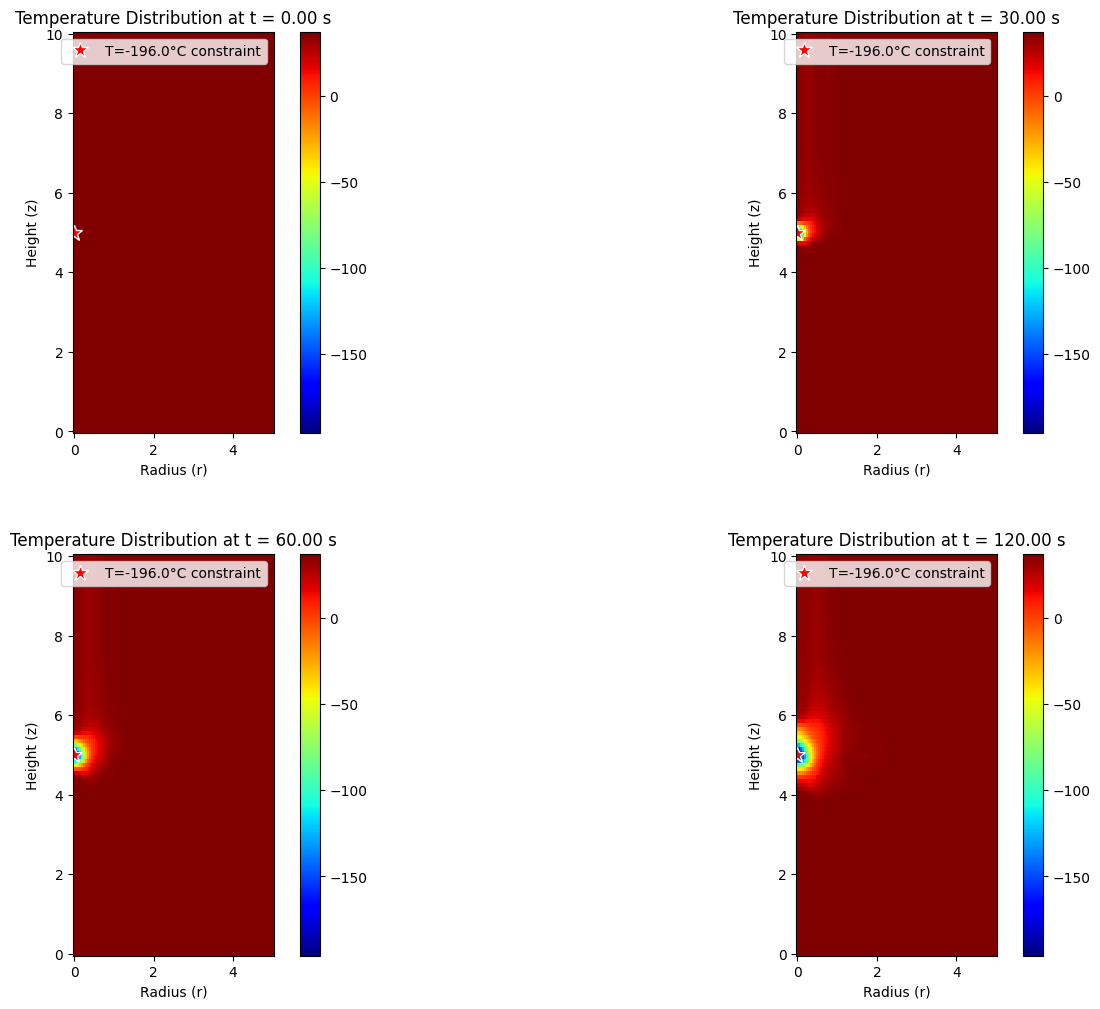

In [ ]:
def plot_temperature_distribution(model):
    print("Visualizing temperature distribution...")
    model.eval()

    if not os.path.exists("pinn_results"):
        os.makedirs("pinn_results")

    vis_times = [0.0, t_end / 4, t_end / 2, t_end]

    r = np.linspace(r_min, r_max, 100)
    z = np.linspace(z_min, z_max, 100)
    R, Z = np.meshgrid(r, z)

    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(2, 2, figure=fig, wspace=0.4, hspace=0.3)

    with torch.no_grad():
        for i, t_val in enumerate(vis_times):
            ax = fig.add_subplot(gs[i // 2, i % 2])

            t_slice = torch.full_like(torch.from_numpy(R.flatten()).float(), t_val)
            r_slice = torch.from_numpy(R.flatten()).float()
            z_slice = torch.from_numpy(Z.flatten()).float()

            t_tensor = t_slice.unsqueeze(1).to(device)
            r_tensor = r_slice.unsqueeze(1).to(device)
            z_tensor = z_slice.unsqueeze(1).to(device)

            T_pred = model(t_tensor, r_tensor, z_tensor).cpu().numpy()
            T_grid = T_pred.reshape(R.shape)

            c = ax.pcolormesh(
                R, Z, T_grid, cmap="jet", shading="auto", vmin=T_p, vmax=T_o
            )
            fig.colorbar(c, ax=ax)
            ax.set_title(f"Temperature Distribution at t = {t_val:.2f} s")
            ax.set_xlabel("Radius (r)")
            ax.set_ylabel("Height (z)")
            ax.plot(
                0,
                z_p,
                "r*",
                markersize=12,
                markeredgecolor="white",
                label=f"T={T_p}°C constraint",
            )
            ax.legend()
            ax.set_aspect("equal", "box")

    plt.savefig("pinn_results/temperature_distribution.png", dpi=300)
    plt.show()


def plot_r_profile(model, r):
    print(f"Visualizing initial condition profile (z vs T at r={r})...")
    model.eval()

    fig, ax = plt.subplots(figsize=(10, 6))

    z_eval = torch.linspace(z_min, z_max, 200).unsqueeze(1).to(device)

    r_eval = torch.full_like(z_eval, r)

    t_values_to_plot = [0.0, 30.0, 120.0]

    with torch.no_grad():
        for t_val in t_values_to_plot:
            t_tensor = torch.full_like(z_eval, t_val)
            T_vals = model(t_tensor, r_eval, z_eval).cpu().numpy()
            ax.plot(z_eval.cpu().numpy(), T_vals, label=f"t = {t_val:.2f}")

    ax.set_title(f"T vs. z at r={r}")
    ax.set_xlabel("Height (z)")
    ax.set_ylabel("Temperature (T)")
    ax.grid(True)
    # ax.set_ylim(-200, 40)
    ax.legend()
    plt.show()


plot_temperature_distribution(model)

## Model results compared to reference solution

In [ ]:
def compare_pinn_with_data(model: nn.Module, csv_filepath: str):
    try:
        device = next(model.parameters()).device
        print(f"Model is on device: {device}")
    except StopIteration:
        device = torch.device("cpu")
        print("Model has no parameters. Using device: cpu")

    try:
        df = pd.read_csv(csv_filepath)
        print(f"Successfully loaded data with {len(df)} points.")
    except FileNotFoundError:
        print(f"Error: The file '{csv_filepath}' was not found.")
        return

    t_data = torch.tensor(df["Time"].values, dtype=torch.float32).view(-1, 1).to(device)
    r_data = torch.tensor(df["r"].values, dtype=torch.float32).view(-1, 1).to(device)
    z_data = torch.tensor(df["z"].values, dtype=torch.float32).view(-1, 1).to(device)
    T_true = (
        torch.tensor(df["Temperature"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )

    model.eval()
    with torch.no_grad():
        T_pred = model(t_data, r_data, z_data)

    rmse = torch.sqrt(torch.mean((T_pred - T_true) ** 2))
    mae = torch.mean(torch.abs(T_pred - T_true))
    relative_l2_error = torch.linalg.norm(T_pred - T_true) / torch.linalg.norm(T_true)

    print("\nComparison Metrics:")
    print(f"  Root Mean Squared Error (RMSE): {rmse.item():.6f}")
    print(f"  Mean Absolute Error (MAE): {mae.item():.6f}")
    print(f"  Relative L2 Error: {relative_l2_error.item():.4%}")

    return rmse.item(), mae.item(), relative_l2_error.item()


rmse, mae, relative_l2_error = compare_pinn_with_data(
    model, "cryo_temperature_data.csv"
)

Model is on device: cuda:0
Successfully loaded data with 330 points.

Comparison Metrics:
  Root Mean Squared Error (RMSE): 1.655743
  Mean Absolute Error (MAE): 0.510887
  Relative L2 Error: 3.7855%


## Saving model weights

In [ ]:
PATH = f"model_weights_adam_{num_epochs}_bfgs_{lbfgs_epochs}_{relative_l2_error}.pth"

torch.save(model.state_dict(), PATH)